## 확률 모델
- 로지스틱 회귀, 나이브 베이즈 등의 확률 모델들은 cut-off value, c를 조정하는 방식으로 비용 민감 모델을 구현할 수 있음
- 정확한 확률 추정은 불가능하지만 그 개념을 도입할 수 있는 모델(k-최근접 이웃, 신경망, 의사결정나무, 앙상블 모델 등)에도 역시 정용이 가능함
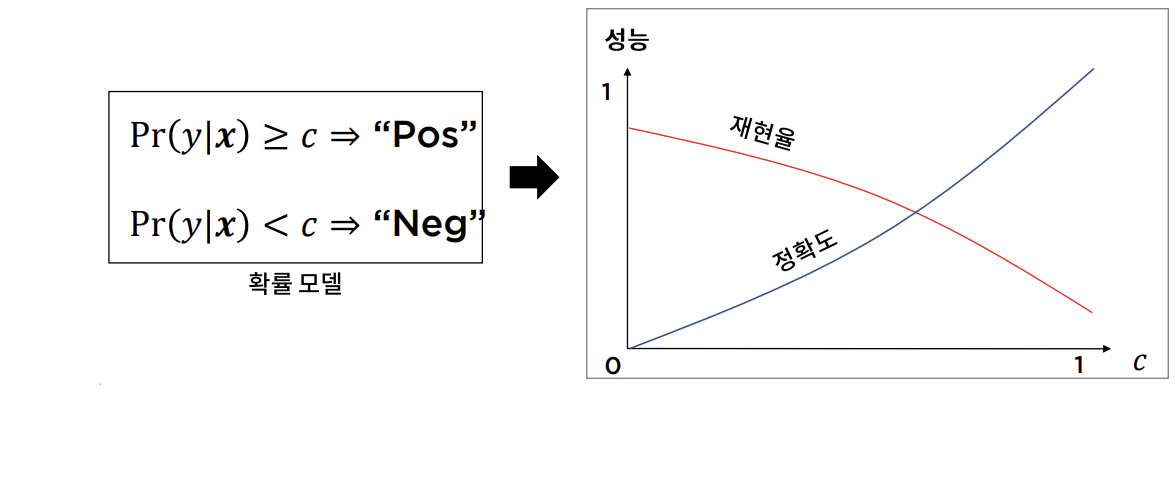

### predict_proba
- sklearn의 확률 모델이 갖는 메서드(fit 이후)로서, X를 입력으로 받아 각 클래스에 속할 확률을 출력
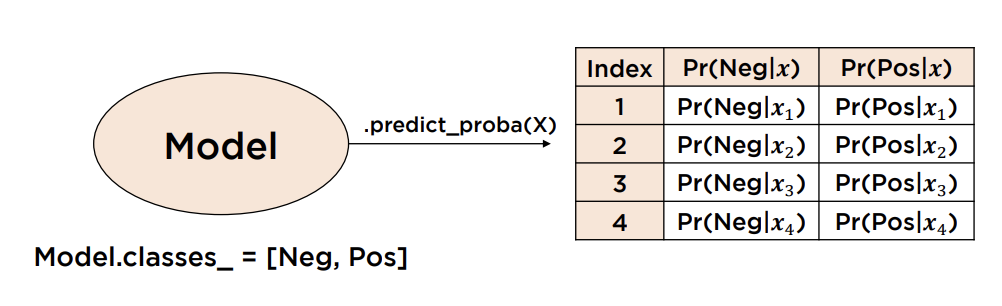

### class_weight
- DecisionTreeClassifier, SVC, RandomForestClassifier 등에서는 class_weight라는 파라미터가 있으며, 사전 형태로 입력함
- key: class(이름) (예: C1)
- value: class weight(예:10)
- 예시: SVC(class_weight = {1:10,-1:1}) => 클래스 1에 클래스 -1보다 10배의 가중치를 부여

In [1]:
import os
import pandas as pd
os.chdir(r'C:\Users\신상훈\Desktop\preprocessing\part-5.-머신러닝-모델의-성능-향상을-위한-전처리\5. 머신러닝 모델의 성능 향상을 위한 전처리\데이터')

In [2]:
df = pd.read_csv('Secom.csv')

In [4]:
# 특징과 라벨 분리
X = df.drop('Y', axis= 1)
Y = df['Y']

In [5]:
# 학습 데이터와 평가 데이터 분할
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y)

In [6]:
# 특징이 매우 많음을 확인
Train_X.shape

(1175, 590)

In [7]:
# 클래스 불균형 확인
Train_Y.value_counts()

-1    1092
 1      83
Name: Y, dtype: int64

In [8]:
# 클래스 불균형 비율 계산
Train_Y.value_counts().iloc[0] / Train_Y.value_counts().iloc[-1]

13.156626506024097

In [9]:
# kNN을 사용한 클래스 불균형 테스트
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import *
kNN_model = KNN(n_neighbors = 11).fit(Train_X, Train_Y)
pred_Y = kNN_model.predict(Test_X)
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))

# 재현율이 0%로 불균형이 심각한 수준이라 보임

0.0
0.9464285714285714


In [10]:
# 비용 민감 모델 적용전 Logistic Regression 모델 테스트
from sklearn.linear_model import LogisticRegression as LR
model = LR(max_iter = 100000).fit(Train_X, Train_Y)
pred_Y = model.predict(Test_X)
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))

0.23809523809523808
0.9081632653061225


C:\Users\신상훈\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# cut off value를 조정
probs = model.predict_proba(Test_X)
probs = pd.DataFrame(probs, columns = model.classes_)

cut_off_value = 0.3

pred_Y = 2 * (probs.iloc[:, -1] >= cut_off_value) - 1
print(recall_score(Test_Y, pred_Y))
print(accuracy_score(Test_Y, pred_Y))

0.3333333333333333
0.8877551020408163


In [12]:
# cut off value를 조정하는 함수 작성
def cost_sensitive_model(model, cut_off_value, Test_X, Test_Y):
    probs = model.predict_proba(Test_X)
    probs = pd.DataFrame(probs, columns = model.classes_)
    pred_Y = 2 * (probs.iloc[:, -1] >= cut_off_value) - 1
    recall = recall_score(Test_Y, pred_Y)
    accuracy = accuracy_score(Test_Y, pred_Y)
    return recall, accuracy

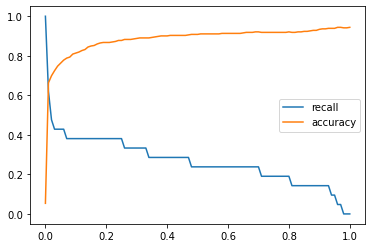

In [13]:
# cut off value에 따른 recall과 accuracy 변화 확인
from matplotlib import pyplot as plt
import numpy as np

cut_off_value_list = np.linspace(0, 1, 101)
recall_list = []
accuracy_list = []

for c in cut_off_value_list:
    recall, accuracy = cost_sensitive_model(model, c, Test_X, Test_Y)
    recall_list.append(recall)
    accuracy_list.append(accuracy)

%matplotlib inline    
plt.plot(cut_off_value_list, recall_list, label = 'recall')   
plt.plot(cut_off_value_list, accuracy_list, label = 'accuracy')    
plt.legend()